# The Bullwhip Effect: Interactive Analysis (Solution)

## Overview
The bullwhip effect is a supply chain phenomenon where order variability increases as we move up the supply chain from end consumer to raw materials supplier. This notebook provides an interactive exploration of this effect through simulation and analysis.

## Learning Objectives
1. Understand the causes of the bullwhip effect
2. Quantify demand amplification
3. Simulate various supply chain scenarios
4. Analyze mitigation strategies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Part 1: Demand Pattern Generation

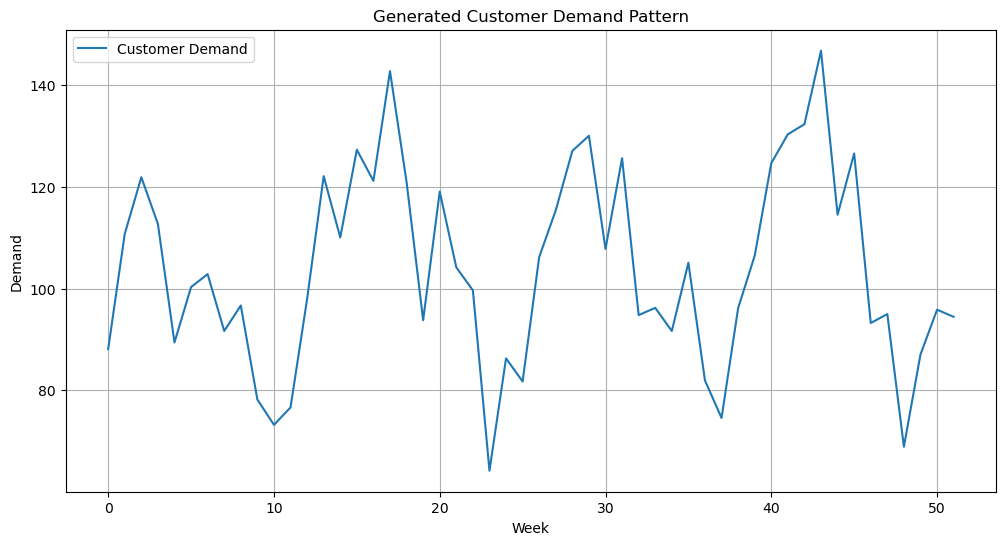

In [2]:
def generate_demand(n_periods, base_demand=100, trend=0.1, seasonality=0.2, noise=0.1):
    """Generate demand pattern with trend, seasonality, and noise"""
    t = np.arange(n_periods)
    
    # Trend component
    trend_component = base_demand * (1 + trend * t/n_periods)
    
    # Seasonality component (using sine wave)
    season_component = base_demand * seasonality * np.sin(2 * np.pi * t / (n_periods/4))
    
    # Random noise component
    noise_component = np.random.normal(0, noise * base_demand, n_periods)
    
    # Combine components
    demand = trend_component + season_component + noise_component
    
    # Ensure non-negative demand
    return np.maximum(demand, 0)

# Generate and plot example demand
n_periods = 52  # Weekly demand for a year
demand = generate_demand(n_periods)

plt.figure(figsize=(12, 6))
plt.plot(demand, label='Customer Demand')
plt.title('Generated Customer Demand Pattern')
plt.xlabel('Week')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()

## Part 2: Supply Chain Simulation

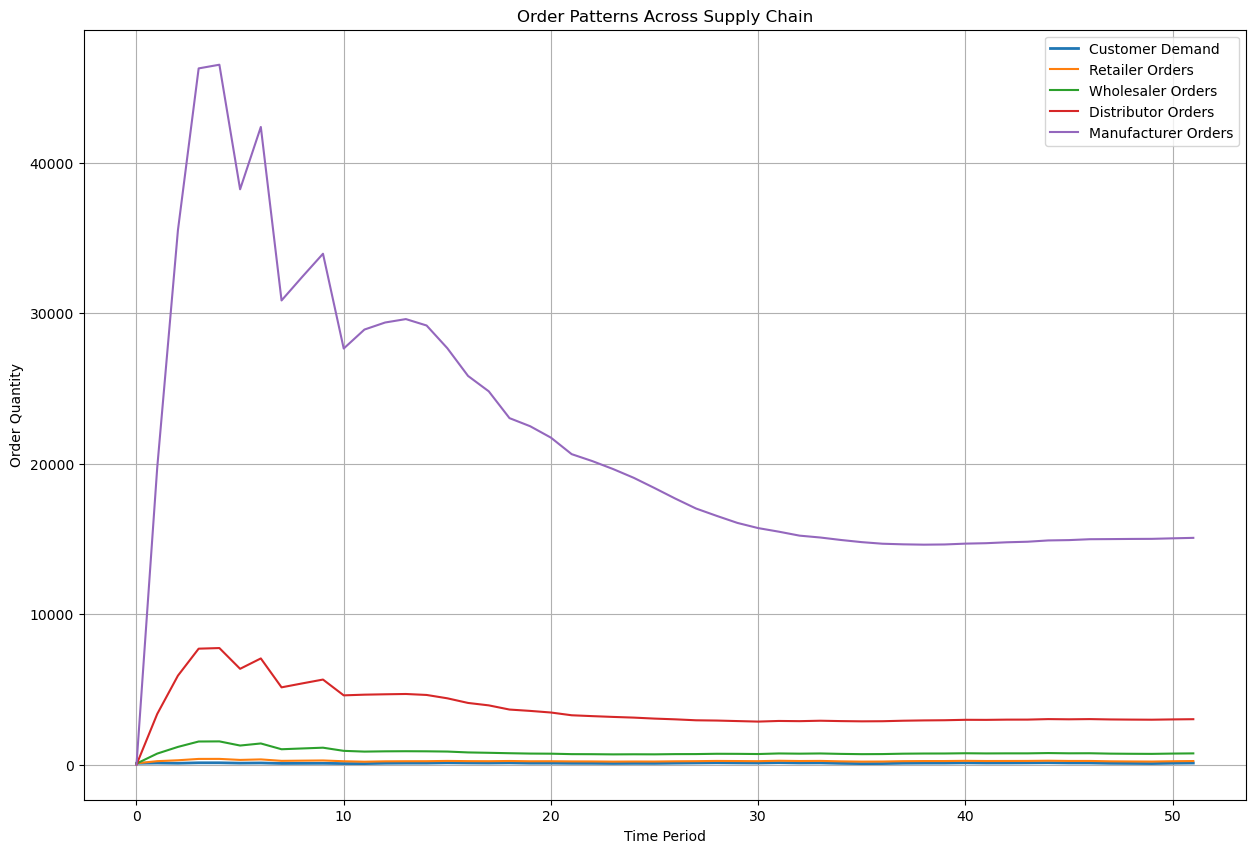

In [3]:
class SupplyChainNode:
    def __init__(self, name, lead_time, initial_inventory, safety_stock_factor=1.5):
        self.name = name
        self.lead_time = lead_time
        self.inventory = initial_inventory
        self.safety_stock_factor = safety_stock_factor
        self.order_history = []
        self.inventory_history = [initial_inventory]
        self.demand_history = []
        self.backlog = 0
        
    def calculate_order_quantity(self, demand):
        # Simple order-up-to policy
        avg_demand = np.mean(self.demand_history[-12:]) if len(self.demand_history) >= 12 else demand
        safety_stock = self.safety_stock_factor * np.std(self.demand_history[-12:]) if len(self.demand_history) >= 12 else demand
        target_inventory = avg_demand * self.lead_time + safety_stock
        order_quantity = max(0, target_inventory - self.inventory + demand)
        return order_quantity
    
    def place_order(self, demand):
        self.demand_history.append(demand)
        order_quantity = self.calculate_order_quantity(demand)
        self.order_history.append(order_quantity)
        
        # Update inventory
        available = min(demand + self.backlog, self.inventory)
        self.inventory -= available
        self.backlog = demand + self.backlog - available
        self.inventory_history.append(self.inventory)
        
        return order_quantity

def simulate_supply_chain(customer_demand, n_nodes=4):
    # Initialize supply chain nodes
    nodes = [
        SupplyChainNode('Retailer', lead_time=1, initial_inventory=200),
        SupplyChainNode('Wholesaler', lead_time=2, initial_inventory=300),
        SupplyChainNode('Distributor', lead_time=3, initial_inventory=400),
        SupplyChainNode('Manufacturer', lead_time=4, initial_inventory=500)
    ]
    
    # Run simulation
    for t, demand in enumerate(customer_demand):
        current_demand = demand
        for node in nodes:
            current_demand = node.place_order(current_demand)
    
    return nodes

# Run simulation
customer_demand = generate_demand(n_periods)
nodes = simulate_supply_chain(customer_demand)

# Plot results
plt.figure(figsize=(15, 10))
plt.plot(customer_demand, label='Customer Demand', linewidth=2)
for node in nodes:
    plt.plot(node.order_history, label=f'{node.name} Orders')
plt.title('Order Patterns Across Supply Chain')
plt.xlabel('Time Period')
plt.ylabel('Order Quantity')
plt.legend()
plt.grid(True)
plt.show()

## Part 3: Analysis and Visualization

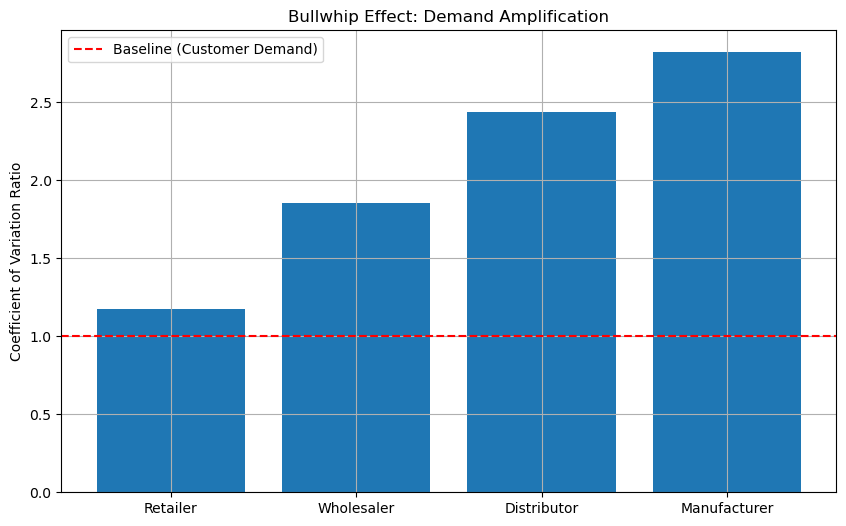


Amplification Ratios:
Retailer: 1.17x
Wholesaler: 1.86x
Distributor: 2.43x
Manufacturer: 2.82x


In [4]:
def analyze_bullwhip(nodes, customer_demand):
    # Calculate variability ratios
    base_cv = np.std(customer_demand) / np.mean(customer_demand)
    amplification_ratios = []
    
    for node in nodes:
        cv = np.std(node.order_history) / np.mean(node.order_history)
        amplification_ratios.append(cv / base_cv)
    
    # Plot amplification ratios
    plt.figure(figsize=(10, 6))
    plt.bar(['Retailer', 'Wholesaler', 'Distributor', 'Manufacturer'], amplification_ratios)
    plt.axhline(y=1, color='r', linestyle='--', label='Baseline (Customer Demand)')
    plt.title('Bullwhip Effect: Demand Amplification')
    plt.ylabel('Coefficient of Variation Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return amplification_ratios

# Analyze results
amplification_ratios = analyze_bullwhip(nodes, customer_demand)
print('\nAmplification Ratios:')
for node, ratio in zip(['Retailer', 'Wholesaler', 'Distributor', 'Manufacturer'], amplification_ratios):
    print(f'{node}: {ratio:.2f}x')

## Part 4: Mitigation Strategies

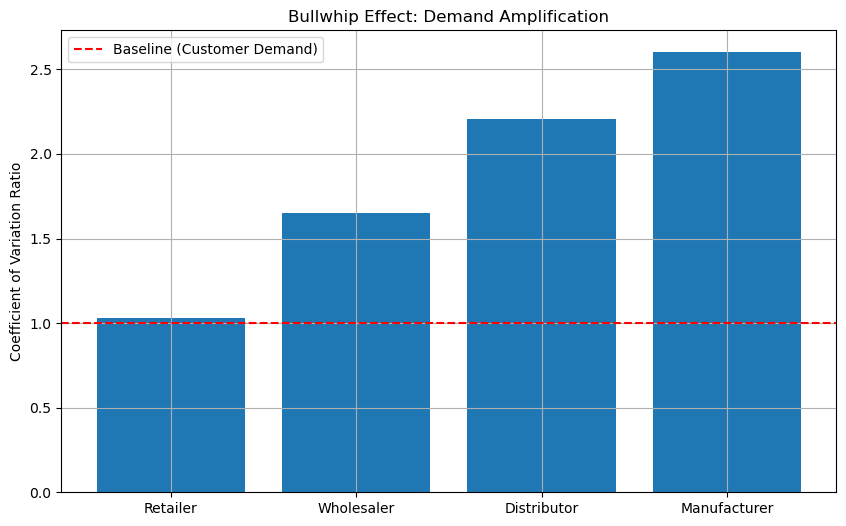

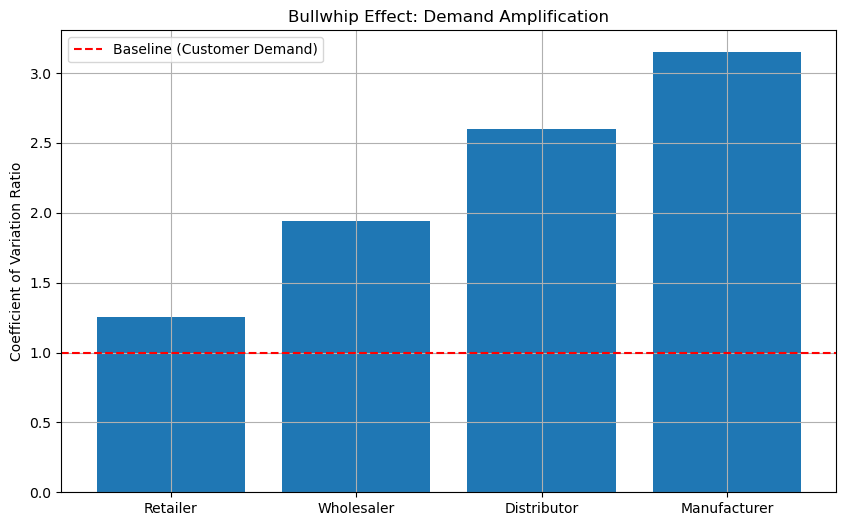

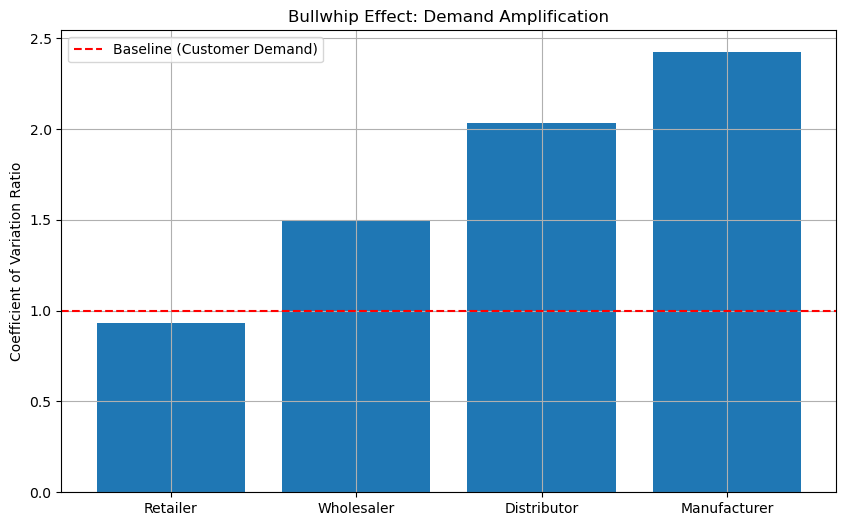

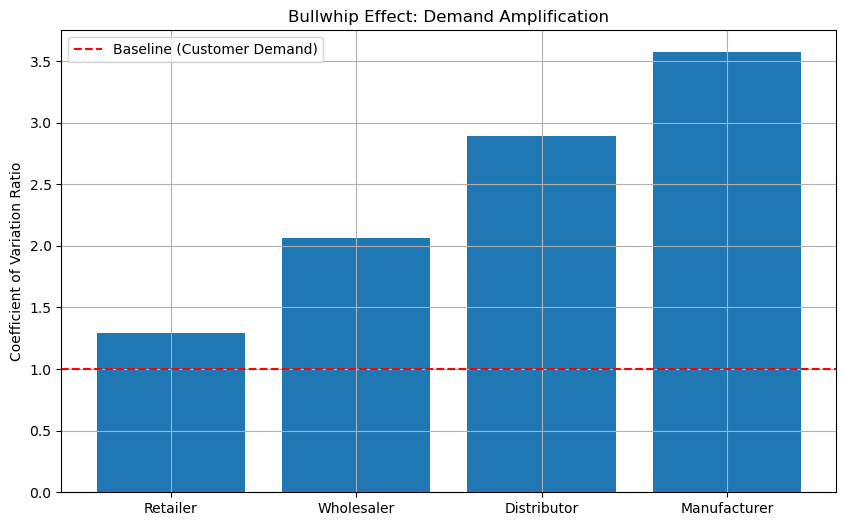

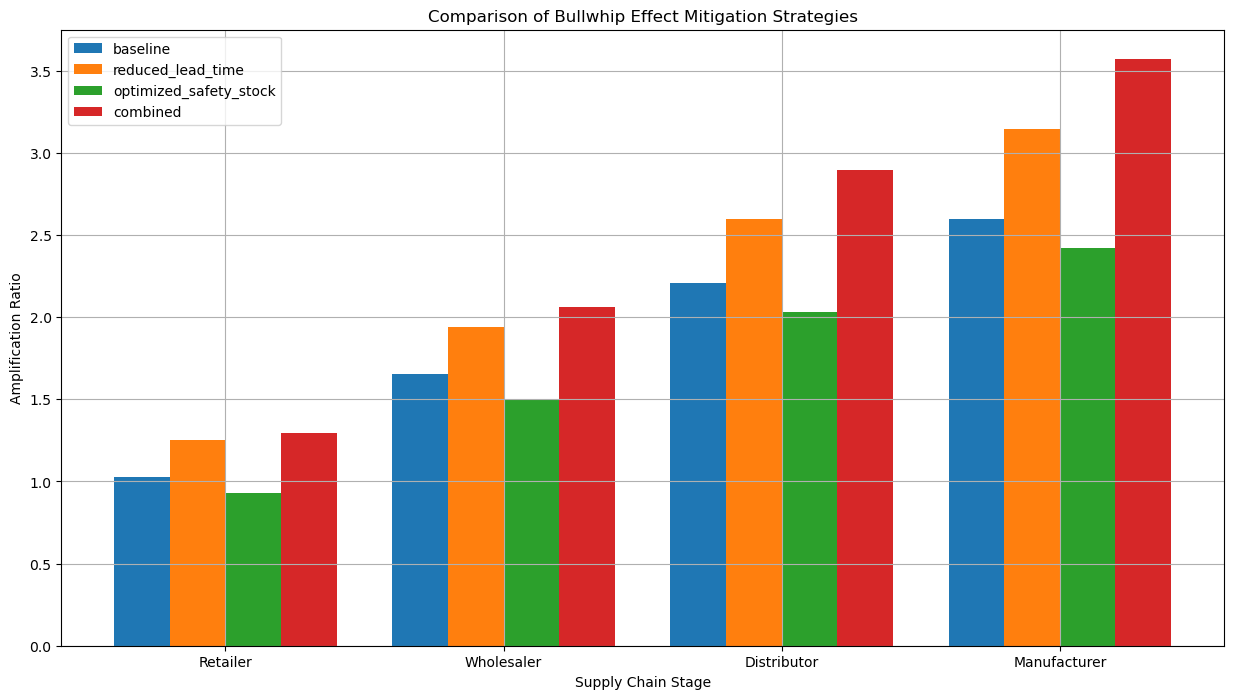


Maximum Amplification Ratios by Strategy:
baseline: 2.60x
reduced_lead_time: 3.15x
optimized_safety_stock: 2.42x
combined: 3.57x


In [5]:
def implement_mitigation(strategy, lead_times=[1, 2, 3, 4], safety_stocks=[1.5, 1.5, 1.5, 1.5]):
    """Implement and test different mitigation strategies"""
    if strategy == 'baseline':
        return lead_times, safety_stocks
    
    elif strategy == 'reduced_lead_time':
        # Reduce lead times by 50%
        return [lt/2 for lt in lead_times], safety_stocks
    
    elif strategy == 'optimized_safety_stock':
        # Decrease safety stock levels upstream
        return lead_times, [1.5, 1.3, 1.1, 1.0]
    
    elif strategy == 'combined':
        # Combine both strategies
        return [lt/2 for lt in lead_times], [1.5, 1.3, 1.1, 1.0]

# Test different strategies
strategies = ['baseline', 'reduced_lead_time', 'optimized_safety_stock', 'combined']
results = {}

for strategy in strategies:
    # Initialize supply chain with strategy parameters
    lead_times, safety_stocks = implement_mitigation(strategy)
    nodes = [
        SupplyChainNode('Retailer', lead_times[0], 200, safety_stocks[0]),
        SupplyChainNode('Wholesaler', lead_times[1], 300, safety_stocks[1]),
        SupplyChainNode('Distributor', lead_times[2], 400, safety_stocks[2]),
        SupplyChainNode('Manufacturer', lead_times[3], 500, safety_stocks[3])
    ]
    
    # Run simulation
    customer_demand = generate_demand(n_periods)
    for t, demand in enumerate(customer_demand):
        current_demand = demand
        for node in nodes:
            current_demand = node.place_order(current_demand)
    
    # Calculate amplification ratios
    results[strategy] = analyze_bullwhip(nodes, customer_demand)

# Compare strategies
plt.figure(figsize=(15, 8))
x = np.arange(4)
width = 0.2

for i, (strategy, ratios) in enumerate(results.items()):
    plt.bar(x + i*width, ratios, width, label=strategy)

plt.xlabel('Supply Chain Stage')
plt.ylabel('Amplification Ratio')
plt.title('Comparison of Bullwhip Effect Mitigation Strategies')
plt.xticks(x + width*1.5, ['Retailer', 'Wholesaler', 'Distributor', 'Manufacturer'])
plt.legend()
plt.grid(True)
plt.show()

# Print summary statistics
print('\nMaximum Amplification Ratios by Strategy:')
for strategy, ratios in results.items():
    print(f'{strategy}: {max(ratios):.2f}x')